In [14]:
import os
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [3]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [82]:
sr = 44100
input_length = int(sr/2)
batch_size = 32


def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=sr)[0] 
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

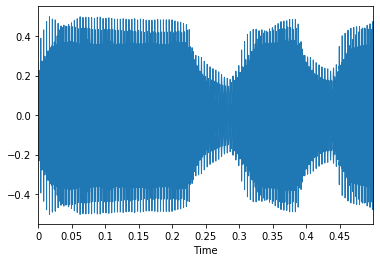

In [83]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=sr, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [84]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [85]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.sr = 44100
        self.input_length = int(sr/2)
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [86]:
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [87]:
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=32, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=32, shuffle=32)

# Model

In [88]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_256_3 = nn.Conv1d(in_channels=32, out_channels=256, kernel_size=3, padding=True)
        self.conv1d_256_256_3 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_10752_64 = nn.Linear(in_features=5376, out_features=64)
        self.fc_64_1024 = nn.Linear(in_features=64, out_features=1024)
        self.fc_1024_42 = nn.Linear(in_features=1024, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_256_3(x)
        x = self.relu(x)
        x = self.conv1d_256_256_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_10752_64(x)
        x = self.relu(x)
        x = self.fc_64_1024(x)
        x = self.relu(x)
        x = self.fc_1024_42(x)
        x = self.softmax(x)
        
        return x

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 22050))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 22044]             160
              ReLU-2            [-1, 16, 22044]               0
            Conv1d-3            [-1, 16, 22038]           2,320
              ReLU-4            [-1, 16, 22038]               0
         MaxPool1d-5             [-1, 16, 1377]               0
           Dropout-6             [-1, 16, 1377]               0
            Conv1d-7             [-1, 32, 1377]           1,568
              ReLU-8             [-1, 32, 1377]               0
            Conv1d-9             [-1, 32, 1377]           3,104
             ReLU-10             [-1, 32, 1377]               0
        MaxPool1d-11              [-1, 32, 344]               0
          Dropout-12              [-1, 32, 344]               0
           Conv1d-13              [-1, 32, 344]           3,104
             ReLU-14              [-1, 

In [155]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
epoch_progress_bar = tqdm.tqdm(range(0, 1000))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*32)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*32)))


Epoch Loss:  3.6289583278607718
Train Acc  14.926160337552743



Valid Acc  14.427083333333334



Epoch Loss:  3.6225448268375318
Train Acc  15.50632911392405



Valid Acc  14.6875



Epoch Loss:  3.616288606627581
Train Acc  16.060126582278482



Valid Acc  15.364583333333334



Epoch Loss:  3.614896489598077
Train Acc  16.178797468354432



Valid Acc  16.25



Epoch Loss:  3.613043165408106
Train Acc  16.495253164556964



Valid Acc  15.416666666666666



Epoch Loss:  3.6076271644624476
Train Acc  16.904008438818565



Valid Acc  14.895833333333334



Epoch Loss:  3.603439758598553
Train Acc  17.3918776371308



Valid Acc  16.197916666666668



Epoch Loss:  3.6068756540113363
Train Acc  17.07542194092827



Valid Acc  16.354166666666668



Epoch Loss:  3.600664042219331
Train Acc  17.64240506329114



Valid Acc  17.395833333333332



Epoch Loss:  3.5985285632217985
Train Acc  17.906118143459917



Valid Acc  16.71875



Epoch Loss:  3.603044575276757
Train Acc  17.51054852320675



Valid Acc  16.927083333333332



Epoch Loss:  3.6042256224507523
Train Acc  17.352320675105485



Valid Acc  17.8125



Epoch Loss:  3.601158870423393
Train Acc  17.708333333333332



Valid Acc  17.239583333333332



Epoch Loss:  3.598123066535982
Train Acc  18.143459915611814



Valid Acc  17.447916666666668



Epoch Loss:  3.6053321663337417
Train Acc  17.246835443037973



Valid Acc  17.65625



Epoch Loss:  3.5966551495000783
Train Acc  18.1039029535865



Valid Acc  17.708333333333332



Epoch Loss:  3.5966345740773003
Train Acc  17.95886075949367



Valid Acc  17.760416666666668



Epoch Loss:  3.597079251888935
Train Acc  18.037974683544302



Valid Acc  18.4375



Epoch Loss:  3.5969465312072497
Train Acc  17.985232067510548



Valid Acc  16.822916666666668



Epoch Loss:  3.596876486444272
Train Acc  18.130274261603375



Valid Acc  18.489583333333332



Epoch Loss:  3.5938075715479467
Train Acc  18.328059071729957



Valid Acc  17.65625



Epoch Loss:  3.5925298360832634
Train Acc  18.5126582278481



Valid Acc  18.489583333333332



Epoch Loss:  3.593817038878107
Train Acc  18.22257383966245



Valid Acc  19.0625



Epoch Loss:  3.5918662437406774
Train Acc  18.52584388185654



Valid Acc  17.864583333333332



Epoch Loss:  3.5890343330077483
Train Acc  18.9873417721519



Valid Acc  18.385416666666668



Epoch Loss:  3.5938719375224055
Train Acc  18.42035864978903



Valid Acc  18.177083333333332



Epoch Loss:  3.5903264258984273
Train Acc  18.64451476793249



Valid Acc  18.802083333333332



Epoch Loss:  3.587713811970964
Train Acc  19.132383966244724



Valid Acc  18.645833333333332



Epoch Loss:  3.58306013582125
Train Acc  19.475210970464136



Valid Acc  17.864583333333332



Epoch Loss:  3.5848940897591506
Train Acc  19.264240506329113



Valid Acc  19.166666666666668



Epoch Loss:  3.5840519550983414
Train Acc  19.382911392405063



Valid Acc  18.020833333333332



Epoch Loss:  3.5835535486036214
Train Acc  19.475210970464136



Valid Acc  19.21875



Epoch Loss:  3.5838029807126977
Train Acc  19.19831223628692



Valid Acc  20.78125



Epoch Loss:  3.588875209228902
Train Acc  18.86867088607595



Valid Acc  18.125



Epoch Loss:  3.5806479645177784
Train Acc  19.593881856540083



Valid Acc  18.541666666666668



Epoch Loss:  3.582253142248226
Train Acc  19.488396624472575



Valid Acc  19.166666666666668



Epoch Loss:  3.581668683748205
Train Acc  19.54113924050633



Valid Acc  20.364583333333332



Epoch Loss:  3.5787107481735165
Train Acc  19.936708860759495



Valid Acc  19.0625



Epoch Loss:  3.5857976076472156
Train Acc  19.251054852320674



Valid Acc  18.4375



Epoch Loss:  3.5759589812926604
Train Acc  20.09493670886076



Valid Acc  19.479166666666668



Epoch Loss:  3.577148356015169
Train Acc  20.1081223628692



Valid Acc  19.010416666666668



Epoch Loss:  3.5801754219119557
Train Acc  19.791666666666668



Valid Acc  19.114583333333332



Epoch Loss:  3.578585059330936
Train Acc  19.936708860759495



Valid Acc  19.010416666666668



Epoch Loss:  3.5765163888408162
Train Acc  20.147679324894515



Valid Acc  19.479166666666668



Epoch Loss:  3.575809146784529
Train Acc  20.20042194092827



Valid Acc  21.822916666666668



Epoch Loss:  3.579409956429075
Train Acc  19.75210970464135



Valid Acc  20.364583333333332



Epoch Loss:  3.5763321456023913
Train Acc  20.121308016877638



Valid Acc  19.427083333333332



Epoch Loss:  3.569659128470763
Train Acc  20.912447257383967



Valid Acc  19.739583333333332



Epoch Loss:  3.577032595244138
Train Acc  20.1081223628692



Valid Acc  19.84375



Epoch Loss:  3.578919171281002
Train Acc  19.804852320675106



Valid Acc  20.104166666666668



Epoch Loss:  3.5729515632999598
Train Acc  20.477320675105485



Valid Acc  21.145833333333332



Epoch Loss:  3.5722800407731583
Train Acc  20.503691983122362



Valid Acc  20.15625



Epoch Loss:  3.5765278942977328
Train Acc  19.97626582278481



Valid Acc  18.177083333333332



Epoch Loss:  3.571647242654728
Train Acc  20.675105485232066



Valid Acc  18.854166666666668



Epoch Loss:  3.573704011329619
Train Acc  20.43776371308017



Valid Acc  19.114583333333332



Epoch Loss:  3.5766998625002833
Train Acc  20.134493670886076



Valid Acc  19.010416666666668



Epoch Loss:  3.572454327772438
Train Acc  20.63554852320675



Valid Acc  19.53125



Epoch Loss:  3.577267731292338
Train Acc  20.015822784810126



Valid Acc  19.0625



Epoch Loss:  3.573059115228774
Train Acc  20.42457805907173



Valid Acc  20.78125



Epoch Loss:  3.5718793386145484
Train Acc  20.569620253164558



Valid Acc  19.427083333333332



Epoch Loss:  3.5687537967907224
Train Acc  20.925632911392405



Valid Acc  18.229166666666668



Epoch Loss:  3.5732193898551072
Train Acc  20.43776371308017



Valid Acc  20.0



Epoch Loss:  3.569917245253229
Train Acc  20.89926160337553



Valid Acc  20.625



Epoch Loss:  3.576096879782053
Train Acc  20.09493670886076



Valid Acc  20.78125



Epoch Loss:  3.5794050824290085
Train Acc  19.73892405063291



Valid Acc  20.260416666666668



Epoch Loss:  3.5657511511935462
Train Acc  21.242088607594937



Valid Acc  20.885416666666668



Epoch Loss:  3.5729098692221983
Train Acc  20.450949367088608



Valid Acc  20.9375



Epoch Loss:  3.5710227529710856
Train Acc  20.64873417721519



Valid Acc  21.5625



Epoch Loss:  3.572270528173648
Train Acc  20.569620253164558



Valid Acc  19.895833333333332



Epoch Loss:  3.571602617135028
Train Acc  20.64873417721519



Valid Acc  21.822916666666668



Epoch Loss:  3.5721054620380643
Train Acc  20.490506329113924



Valid Acc  21.09375



Epoch Loss:  3.57227141243496
Train Acc  20.477320675105485



Valid Acc  20.520833333333332



Epoch Loss:  3.569490161123155
Train Acc  20.76740506329114



Valid Acc  19.895833333333332



Epoch Loss:  3.5689899096509072
Train Acc  20.701476793248943



Valid Acc  20.572916666666668



Epoch Loss:  3.565301108460889
Train Acc  21.162974683544302



Valid Acc  19.635416666666668



Epoch Loss:  3.5689329416943
Train Acc  20.952004219409282



Valid Acc  20.885416666666668



Epoch Loss:  3.5665507407128056
Train Acc  21.031118143459917



Valid Acc  19.739583333333332



Epoch Loss:  3.572095840792113
Train Acc  20.595991561181435



Valid Acc  20.416666666666668



Epoch Loss:  3.566506364677526
Train Acc  21.09704641350211



Valid Acc  21.25



Epoch Loss:  3.5701374917090694
Train Acc  20.64873417721519



Valid Acc  20.572916666666668



Epoch Loss:  3.571026106926962
Train Acc  20.582805907172997



Valid Acc  19.791666666666668



Epoch Loss:  3.5735308872496527
Train Acc  20.292721518987342



Valid Acc  21.458333333333332



Epoch Loss:  3.5700344113860956
Train Acc  20.7542194092827



Valid Acc  20.729166666666668



Epoch Loss:  3.5697102244896226
Train Acc  20.76740506329114



Valid Acc  19.21875



Epoch Loss:  3.5816087471281928
Train Acc  19.620253164556964



Valid Acc  20.989583333333332



Epoch Loss:  3.5657852027989643
Train Acc  21.149789029535864



Valid Acc  19.947916666666668



Epoch Loss:  3.564196809937682
Train Acc  21.33438818565401



Valid Acc  20.572916666666668



Epoch Loss:  3.5686934104951624
Train Acc  20.952004219409282



Valid Acc  21.5625



Epoch Loss:  3.567339522929131
Train Acc  21.057489451476794



Valid Acc  19.6875



Epoch Loss:  3.5646391930962413
Train Acc  21.360759493670887



Valid Acc  20.364583333333332



Epoch Loss:  3.5657285527337956
Train Acc  21.2289029535865



Valid Acc  20.9375



Epoch Loss:  3.5656925676241205
Train Acc  21.189345991561183



Valid Acc  20.989583333333332



Epoch Loss:  3.5645230057873305
Train Acc  21.387130801687764



Valid Acc  19.895833333333332



Epoch Loss:  3.567159670817701
Train Acc  21.110232067510548



Valid Acc  20.833333333333332



Epoch Loss:  3.573297307461123
Train Acc  20.398206751054854



Valid Acc  21.614583333333332



Epoch Loss:  3.569635487809966
Train Acc  20.806962025316455



Valid Acc  21.09375



Epoch Loss:  3.5624206428286396
Train Acc  21.360759493670887



Valid Acc  21.875



Epoch Loss:  3.56159850011898
Train Acc  21.492616033755276



Valid Acc  20.9375



Epoch Loss:  3.562763384122889
Train Acc  21.42668776371308



Valid Acc  20.78125



Epoch Loss:  3.559587523907046
Train Acc  21.822257383966246



Valid Acc  21.354166666666668



Epoch Loss:  3.56393665502846
Train Acc  21.255274261603375



Valid Acc  21.71875



Epoch Loss:  3.5623236446943967
Train Acc  21.453059071729957



Valid Acc  20.885416666666668



Epoch Loss:  3.5599208853918793
Train Acc  21.74314345991561



Valid Acc  20.572916666666668



Epoch Loss:  3.5634969467855204
Train Acc  21.466244725738395



Valid Acc  21.666666666666668



Epoch Loss:  3.5598493075068993
Train Acc  21.782700421940927



Valid Acc  21.822916666666668



Epoch Loss:  3.5598568181951338
Train Acc  21.690400843881857



Valid Acc  21.25



Epoch Loss:  3.566828071819579
Train Acc  21.004746835443036



Valid Acc  19.53125



Epoch Loss:  3.567904496494728
Train Acc  20.952004219409282



Valid Acc  21.614583333333332



Epoch Loss:  3.5650497418415696
Train Acc  21.149789029535864



Valid Acc  20.729166666666668



Epoch Loss:  3.563465563053823
Train Acc  21.42668776371308



Valid Acc  20.78125



Epoch Loss:  3.5631433076496366
Train Acc  21.373945147679326



Valid Acc  21.875



Epoch Loss:  3.560818566551691
Train Acc  21.67721518987342



Valid Acc  21.770833333333332



Epoch Loss:  3.5644646515826133
Train Acc  21.189345991561183



Valid Acc  21.458333333333332



Epoch Loss:  3.56466320094177
Train Acc  21.34757383966245



Valid Acc  20.416666666666668



Epoch Loss:  3.5652479612374606
Train Acc  21.268459915611814



Valid Acc  21.145833333333332



Epoch Loss:  3.5634891473794283
Train Acc  21.321202531645568



Valid Acc  20.572916666666668



Epoch Loss:  3.562274022444391
Train Acc  21.41350210970464



Valid Acc  20.46875



Epoch Loss:  3.562273554661103
Train Acc  21.62447257383966



Valid Acc  22.552083333333332



Epoch Loss:  3.5608306957196585
Train Acc  21.571729957805907



Valid Acc  19.895833333333332



Epoch Loss:  3.5640611155626645
Train Acc  21.400316455696203



Valid Acc  21.302083333333332



Epoch Loss:  3.554954180737588
Train Acc  22.283755274261605



Valid Acc  21.770833333333332



Epoch Loss:  3.5548110732549354
Train Acc  22.231012658227847



Valid Acc  22.083333333333332



Epoch Loss:  3.5614377043921235
Train Acc  21.505801687763714



Valid Acc  21.40625



Epoch Loss:  3.556734730925741
Train Acc  22.08597046413502



Valid Acc  20.989583333333332



Epoch Loss:  3.5598543736502086
Train Acc  21.66402953586498



Valid Acc  21.5625



Epoch Loss:  3.5590362941162494
Train Acc  21.848628691983123



Valid Acc  20.46875



Epoch Loss:  3.555897262025986
Train Acc  22.151898734177216



Valid Acc  22.135416666666668



Epoch Loss:  3.5551609952741536
Train Acc  22.165084388185655



Valid Acc  22.135416666666668



Epoch Loss:  3.5586927510515043
Train Acc  21.809071729957807



Valid Acc  20.572916666666668



Epoch Loss:  3.5582072382737815
Train Acc  21.940928270042193



Valid Acc  22.34375



Epoch Loss:  3.55608424154515
Train Acc  22.046413502109704



Valid Acc  22.604166666666668



Epoch Loss:  3.555000725677748
Train Acc  22.20464135021097



Valid Acc  21.71875



Epoch Loss:  3.5557072575082254
Train Acc  22.165084388185655



Valid Acc  21.770833333333332



Epoch Loss:  3.5542958979868184
Train Acc  22.349683544303797



Valid Acc  21.770833333333332



Epoch Loss:  3.5554074858814353
Train Acc  22.12552742616034



Valid Acc  21.302083333333332



Epoch Loss:  3.554264805990935
Train Acc  22.310126582278482



Valid Acc  21.510416666666668



Epoch Loss:  3.5590432505064373
Train Acc  21.901371308016877



Valid Acc  21.666666666666668



Epoch Loss:  3.557714584004527
Train Acc  21.848628691983123



Valid Acc  21.041666666666668



Epoch Loss:  3.559541753575772
Train Acc  21.76951476793249



Valid Acc  21.614583333333332



Epoch Loss:  3.5540245806617574
Train Acc  22.270569620253166



Valid Acc  22.708333333333332



Epoch Loss:  3.553261665352286
Train Acc  22.349683544303797



Valid Acc  22.239583333333332



Epoch Loss:  3.5562875924734123
Train Acc  21.967299578059073



Valid Acc  23.177083333333332



Epoch Loss:  3.5558727220140933
Train Acc  22.178270042194093



Valid Acc  21.510416666666668



Epoch Loss:  3.5512123178329147
Train Acc  22.639767932489452



Valid Acc  22.135416666666668



Epoch Loss:  3.5491364314083307
Train Acc  22.87710970464135



Valid Acc  20.3125



Epoch Loss:  3.5542536737546637
Train Acc  22.349683544303797



Valid Acc  20.989583333333332



Epoch Loss:  3.5526735611605744
Train Acc  22.349683544303797



Valid Acc  22.239583333333332



Epoch Loss:  3.5572618402006255
Train Acc  22.1123417721519



Valid Acc  20.9375



Epoch Loss:  3.5544341686908707
Train Acc  22.362869198312236



Valid Acc  22.239583333333332



Epoch Loss:  3.552354356910609
Train Acc  22.507911392405063



Valid Acc  22.395833333333332



Epoch Loss:  3.5561930368721235
Train Acc  21.954113924050635



Valid Acc  21.354166666666668



Epoch Loss:  3.5529243825357173
Train Acc  22.44198312236287



Valid Acc  22.083333333333332



Epoch Loss:  3.5494556095026715
Train Acc  22.824367088607595



Valid Acc  22.03125



Epoch Loss:  3.5582059948756224
Train Acc  21.901371308016877



Valid Acc  22.1875



Epoch Loss:  3.5583761341964144
Train Acc  21.795886075949365



Valid Acc  21.5625



Epoch Loss:  3.5527365036654572
Train Acc  22.481540084388186



Valid Acc  21.614583333333332



Epoch Loss:  3.554853462468723
Train Acc  22.20464135021097



Valid Acc  21.822916666666668



Epoch Loss:  3.557416423966613
Train Acc  22.046413502109704



Valid Acc  22.291666666666668



Epoch Loss:  3.5609720527874265
Train Acc  21.611286919831223



Valid Acc  21.666666666666668



Epoch Loss:  3.5531714002794352
Train Acc  22.389240506329113



Valid Acc  21.041666666666668



Epoch Loss:  3.5544644055990227
Train Acc  22.257383966244724



Valid Acc  21.979166666666668



Epoch Loss:  3.552028403503482
Train Acc  22.600210970464136



Valid Acc  22.083333333333332



Epoch Loss:  3.557330693876693
Train Acc  21.940928270042193



Valid Acc  20.729166666666668



Epoch Loss:  3.5555929513923226
Train Acc  22.270569620253166



Valid Acc  20.885416666666668



Epoch Loss:  3.5554075019772045
Train Acc  22.21782700421941



Valid Acc  22.96875



Epoch Loss:  3.5570963797187
Train Acc  21.927742616033754



Valid Acc  22.8125



Epoch Loss:  3.551521926992553
Train Acc  22.600210970464136



Valid Acc  21.302083333333332



Epoch Loss:  3.5560768606290534
Train Acc  22.21782700421941



Valid Acc  21.40625



Epoch Loss:  3.5555209590412895
Train Acc  22.32331223628692



Valid Acc  20.833333333333332



Epoch Loss:  3.5534613806487134
Train Acc  22.41561181434599



Valid Acc  21.40625



Epoch Loss:  3.5586488106079743
Train Acc  21.74314345991561



Valid Acc  21.822916666666668



Epoch Loss:  3.5522621643694143
Train Acc  22.507911392405063



Valid Acc  22.708333333333332



Epoch Loss:  3.549735670854271
Train Acc  22.705696202531644



Valid Acc  22.760416666666668



Epoch Loss:  3.552428907482936
Train Acc  22.428797468354432



Valid Acc  23.541666666666668



Epoch Loss:  3.5461587614147976
Train Acc  23.088080168776372



Valid Acc  22.864583333333332



Epoch Loss:  3.5496860123887846
Train Acc  22.837552742616033



Valid Acc  22.395833333333332



Epoch Loss:  3.549752963746147
Train Acc  22.837552742616033



Valid Acc  21.510416666666668



Epoch Loss:  3.5535231089290185
Train Acc  22.428797468354432



Valid Acc  21.770833333333332



Epoch Loss:  3.550944711588606
Train Acc  22.65295358649789



Valid Acc  20.729166666666668



Epoch Loss:  3.5467436605364964
Train Acc  23.11445147679325



Valid Acc  22.65625



Epoch Loss:  3.5481200288619674
Train Acc  22.85073839662447



Valid Acc  22.395833333333332



Epoch Loss:  3.5493207561315865
Train Acc  22.797995780590718



Valid Acc  23.125



Epoch Loss:  3.550055526982883
Train Acc  22.66613924050633



Valid Acc  22.5



Epoch Loss:  3.5438155001225855
Train Acc  23.2331223628692



Valid Acc  22.708333333333332



Epoch Loss:  3.5488119950274375
Train Acc  22.85073839662447



Valid Acc  20.78125



Epoch Loss:  3.5447031053309703
Train Acc  23.272679324894515



Valid Acc  22.34375



Epoch Loss:  3.547191575609682
Train Acc  23.140822784810126



Valid Acc  22.291666666666668



Epoch Loss:  3.548119319642143
Train Acc  22.890295358649787



Valid Acc  22.239583333333332



Epoch Loss:  3.546608708578826
Train Acc  23.035337552742615



Valid Acc  23.177083333333332



Epoch Loss:  3.546484418056182
Train Acc  23.19356540084388



Valid Acc  22.1875



Epoch Loss:  3.550127880482734
Train Acc  22.65295358649789



Valid Acc  20.572916666666668



Epoch Loss:  3.550474977694483
Train Acc  22.626582278481013



Valid Acc  21.875



Epoch Loss:  3.5567181331698903
Train Acc  22.138713080168777



Valid Acc  23.28125



Epoch Loss:  3.5462416274638118
Train Acc  23.127637130801688



Valid Acc  21.875



Epoch Loss:  3.547485186580867
Train Acc  22.98259493670886



Valid Acc  22.604166666666668



Epoch Loss:  3.5482608326376743
Train Acc  22.916666666666668



Valid Acc  22.5



Epoch Loss:  3.5564296859226148
Train Acc  22.046413502109704



Valid Acc  21.770833333333332



Epoch Loss:  3.5433774577917427
Train Acc  23.457278481012658



Valid Acc  22.083333333333332



Epoch Loss:  3.5500186294442995
Train Acc  22.718881856540083



Valid Acc  21.770833333333332



Epoch Loss:  3.5494417792131125
Train Acc  22.718881856540083



Valid Acc  22.760416666666668



Epoch Loss:  3.544974809960474
Train Acc  23.21993670886076



Valid Acc  22.1875



Epoch Loss:  3.551004376592515
Train Acc  22.65295358649789



Valid Acc  23.385416666666668



Epoch Loss:  3.545482494660068
Train Acc  23.11445147679325



Valid Acc  22.552083333333332



Epoch Loss:  3.544934393484381
Train Acc  23.259493670886076



Valid Acc  22.760416666666668



Epoch Loss:  3.5419950384630936
Train Acc  23.536392405063292



Valid Acc  22.447916666666668



Epoch Loss:  3.544716113730322
Train Acc  23.31223628691983



Valid Acc  23.125



Epoch Loss:  3.5469757293347066
Train Acc  22.9957805907173



Valid Acc  22.03125



Epoch Loss:  3.548405056764305
Train Acc  22.758438818565402



Valid Acc  23.59375



Epoch Loss:  3.5430123936777878
Train Acc  23.417721518987342



Valid Acc  22.8125



Epoch Loss:  3.554414758199378
Train Acc  22.19145569620253



Valid Acc  22.96875



Epoch Loss:  3.546947625115954
Train Acc  22.98259493670886



Valid Acc  22.916666666666668



Epoch Loss:  3.545172894554299
Train Acc  23.21993670886076



Valid Acc  22.5



Epoch Loss:  3.5467587905594065
Train Acc  23.088080168776372



Valid Acc  21.770833333333332



Epoch Loss:  3.5455299077657707
Train Acc  23.206751054852322



Valid Acc  23.229166666666668



Epoch Loss:  3.545258430489005
Train Acc  23.21993670886076



Valid Acc  22.8125



Epoch Loss:  3.541096327174062
Train Acc  23.668248945147678



Valid Acc  22.916666666666668



Epoch Loss:  3.5431730203990695
Train Acc  23.417721518987342



Valid Acc  22.916666666666668



Epoch Loss:  3.5398624969434134
Train Acc  23.720991561181435



Valid Acc  23.072916666666668



Epoch Loss:  3.546195219337689
Train Acc  23.035337552742615



Valid Acc  22.552083333333332



Epoch Loss:  3.54716387277917
Train Acc  22.969409282700422



Valid Acc  21.927083333333332



Epoch Loss:  3.541322900273126
Train Acc  23.68143459915612



Valid Acc  24.114583333333332



Epoch Loss:  3.5422965655346963
Train Acc  23.523206751054854



Valid Acc  22.1875



Epoch Loss:  3.546113632902314
Train Acc  23.088080168776372



Valid Acc  20.46875



Epoch Loss:  3.5475102235496294
Train Acc  23.035337552742615



Valid Acc  22.447916666666668



Epoch Loss:  3.5485952272696837
Train Acc  22.90348101265823



Valid Acc  20.46875



Epoch Loss:  3.545817555254522
Train Acc  23.140822784810126



Valid Acc  22.291666666666668



Epoch Loss:  3.5434335324331676
Train Acc  23.378164556962027



Valid Acc  22.864583333333332



Epoch Loss:  3.5404278417176838
Train Acc  23.76054852320675



Valid Acc  22.135416666666668



Epoch Loss:  3.5467915424314733
Train Acc  23.048523206751057



Valid Acc  22.395833333333332



Epoch Loss:  3.5433167868022677
Train Acc  23.44409282700422



Valid Acc  22.34375



Epoch Loss:  3.54195299329637
Train Acc  23.510021097046412



Valid Acc  22.8125



Epoch Loss:  3.5392187436421714
Train Acc  23.931962025316455



Valid Acc  24.21875



Epoch Loss:  3.5392019165216118
Train Acc  23.734177215189874



Valid Acc  22.03125



Epoch Loss:  3.541393212628264
Train Acc  23.615506329113924



Valid Acc  22.864583333333332



Epoch Loss:  3.5487933983782676
Train Acc  22.90348101265823



Valid Acc  22.708333333333332



Epoch Loss:  3.5435598248670876
Train Acc  23.351793248945146



Valid Acc  22.864583333333332



Epoch Loss:  3.5370258309167144
Train Acc  24.063818565400844



Valid Acc  22.760416666666668



Epoch Loss:  3.5393409366849102
Train Acc  23.77373417721519



Valid Acc  24.114583333333332



Epoch Loss:  3.543168211788065
Train Acc  23.523206751054854



Valid Acc  23.75



Epoch Loss:  3.5355448008589603
Train Acc  24.156118143459917



Valid Acc  22.708333333333332



Epoch Loss:  3.54136701676413
Train Acc  23.457278481012658



Valid Acc  22.8125



Epoch Loss:  3.543896645936282
Train Acc  23.364978902953588



Valid Acc  22.1875



Epoch Loss:  3.5450537496478245
Train Acc  23.246308016877638



Valid Acc  21.770833333333332



Epoch Loss:  3.545165116273904
Train Acc  23.206751054852322



Valid Acc  23.90625



Epoch Loss:  3.537952680628008
Train Acc  23.945147679324894



Valid Acc  23.072916666666668



Epoch Loss:  3.5411699472097404
Train Acc  23.575949367088608



Valid Acc  21.40625



Epoch Loss:  3.5413917821167895
Train Acc  23.628691983122362



Valid Acc  22.1875



Epoch Loss:  3.5459236062528716
Train Acc  23.167194092827003



Valid Acc  24.166666666666668



Epoch Loss:  3.5504122434286125
Train Acc  22.66613924050633



Valid Acc  23.072916666666668



Epoch Loss:  3.5432846727250498
Train Acc  23.391350210970465



Valid Acc  24.010416666666668



Epoch Loss:  3.5377020926415166
Train Acc  23.839662447257385



Valid Acc  24.010416666666668



Epoch Loss:  3.5431402977005844
Train Acc  23.457278481012658



Valid Acc  23.229166666666668



Epoch Loss:  3.5420373522279633
Train Acc  23.536392405063292



Valid Acc  23.229166666666668



Epoch Loss:  3.5428143925807647
Train Acc  23.536392405063292



Valid Acc  22.864583333333332



Epoch Loss:  3.534375351692554
Train Acc  24.301160337552744



Valid Acc  23.4375



Epoch Loss:  3.5366813673751767
Train Acc  24.077004219409282



Valid Acc  23.958333333333332



Epoch Loss:  3.5380772025273317
Train Acc  23.99789029535865



Valid Acc  24.427083333333332



Epoch Loss:  3.5389781873437425
Train Acc  23.839662447257385



Valid Acc  22.760416666666668



Epoch Loss:  3.5350801592637717
Train Acc  24.129746835443036



Valid Acc  22.083333333333332



Epoch Loss:  3.5339161112338684
Train Acc  24.301160337552744



Valid Acc  23.59375



Epoch Loss:  3.541543230225768
Train Acc  23.483649789029535



Valid Acc  23.072916666666668



Epoch Loss:  3.5376773262828713
Train Acc  23.99789029535865



Valid Acc  23.489583333333332



Epoch Loss:  3.5359727762922457
Train Acc  24.077004219409282



Valid Acc  23.697916666666668



Epoch Loss:  3.5369697844428853
Train Acc  24.077004219409282



Valid Acc  23.4375



Epoch Loss:  3.5338659537995416
Train Acc  24.3539029535865



Valid Acc  23.697916666666668



Epoch Loss:  3.541362618595236
Train Acc  23.56276371308017



Valid Acc  23.541666666666668



Epoch Loss:  3.5339606512447954
Train Acc  24.367088607594937



Valid Acc  23.072916666666668



Epoch Loss:  3.5405152678992677
Train Acc  23.68143459915612



Valid Acc  23.333333333333332



Epoch Loss:  3.5390803029265583
Train Acc  23.800105485232066



Valid Acc  23.541666666666668



Epoch Loss:  3.5403520960345047
Train Acc  23.720991561181435



Valid Acc  22.395833333333332



Epoch Loss:  3.5362341122285224
Train Acc  24.077004219409282



Valid Acc  23.28125



Epoch Loss:  3.5377524301472594
Train Acc  23.945147679324894



Valid Acc  23.489583333333332



Epoch Loss:  3.535739321245926
Train Acc  24.169303797468356



Valid Acc  22.395833333333332


In [128]:
torch.save(Model.state_dict(), "FreeSound_1D_conv_1110_epoch.stDict")

In [154]:
i=0
for data in FreeSoundDataLoader:
    if i==6:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.125 4


[(tensor(30), False),
 (tensor(20), False),
 (tensor(8), False),
 (tensor(25), False),
 (tensor(15), True),
 (tensor(28), False),
 (tensor(18), False),
 (tensor(33), False),
 (tensor(36), False),
 (tensor(23), False),
 (tensor(13), False),
 (tensor(21), False),
 (tensor(4), False),
 (tensor(9), False),
 (tensor(20), False),
 (tensor(10), False),
 (tensor(29), False),
 (tensor(37), False),
 (tensor(35), False),
 (tensor(1), False),
 (tensor(15), True),
 (tensor(26), True),
 (tensor(25), True),
 (tensor(2), False),
 (tensor(30), False),
 (tensor(38), False),
 (tensor(27), False),
 (tensor(14), False),
 (tensor(18), False),
 (tensor(7), False),
 (tensor(26), False),
 (tensor(17), False)]